# Plot nucleolous object features for CX5461 and unperturbed

In [1]:
from campa.tl import Experiment, FeatureExtractor, thresholded_count, thresholded_median
from campa_ana.constants import SOURCE_DIR
from pathlib import Path
from campa.pl import hex2rgb
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad

2022-11-16 14:08:19.954212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 14:08:38.196879: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-16 14:08:40.940527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 14:08:40.940581: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Reading config from /home/icb/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


In [2]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig4'
os.makedirs(str(fig_dir), exist_ok=True)

In [3]:
def add_perturbation_plot(adata):
    # create perturbation_plot column from perturbation_duration column
    p = np.array(adata.obs['perturbation_duration'])
    p[p == 'AZD4573-120'] = 'AZD4573 (2.5h)'
    p[p == 'AZD4573-30'] = 'AZD4573 (1h)'
    p[p == 'CX5461-120'] = 'CX5461 (2.5h)'
    p[p == 'Meayamycin-720'] = 'Meayamycin (12.5h)'
    p[p == 'TSA-30'] = 'TSA (1h)'
    p[p == 'Triptolide-120'] = 'Triptolide (2.5h)'
    p[np.in1d(p, ['DMSO-120', 'DMSO-720', 'normal'])] = 'unperturbed'
    adata.obs['perturbation_plot'] = p
    adata.obs['perturbation_plot'] = adata.obs['perturbation_plot'].astype('category')
    print(adata.obs['perturbation_plot'].cat.categories)
    adata.uns['perturbation_plot_colors'] = ['#377eb8', '#984ea3', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#999999']  #https://gist.github.com/thriveth/8560036


In [4]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad')) 
    for data_dir in exp.data_params['data_dirs']}

In [5]:
# aggregate object statistics, using additional thresholding
for extr in extrs.values():
    _ = extr.get_object_stats(area_threshold=10, agg=['median', thresholded_count, thresholded_median])
# combined adatas for plotting
adata_object_stats = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')

In [6]:
#adata = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')
add_perturbation_plot(adata_object_stats)

Index(['AZD4573 (1h)', 'AZD4573 (2.5h)', 'CX5461 (2.5h)', 'Meayamycin (12.5h)',
       'TSA (1h)', 'Triptolide (2.5h)', 'unperturbed'],
      dtype='object')


In [7]:
cats = ['unperturbed', 'CX5461 (2.5h)']
colors = [adata_object_stats.uns['perturbation_plot_colors'][list(adata_object_stats.obs['perturbation_plot'].cat.categories).index(c)] for c in cats]
colors = np.array(list(map(hex2rgb, colors)))/256.

Text(0, 0.5, 'Area (% of Nucleolus)')

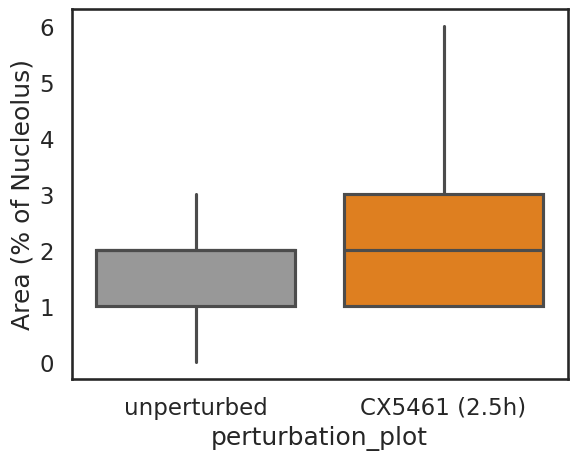

In [8]:
sns.set_style('white')
sns.set_context('talk')

df = adata_object_stats.obsm['size'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
df['nucleolus_fraction'] = df['Nucleolus'] / df['all'] * 100

# object count
#ax = axes[0][0]
df = adata_object_stats.obsm['object_stats_agg'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
g = sns.boxplot(data=df, y='area_thresholded_count|Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False)# ax=ax)
g.set_ylabel('Area (% of Nucleolus)')

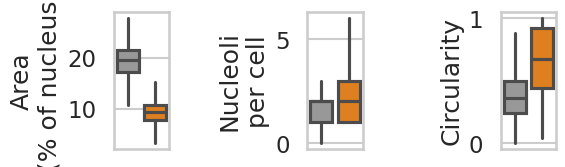

In [16]:
sns.set_style('whitegrid')
sns.set_context('talk')

fig, axes = plt.subplots(1,3, figsize=(6,2), sharex=True, squeeze=False)
# total area 
#ax = axes[0][0]
#df = adata_object_stats.obsm['size'].copy()
#df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
#sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
#ax.set_ylabel('Total area (px)')

# relative area
ax = axes[0][0]
df = adata_object_stats.obsm['size'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
df['nucleolus_fraction'] = df['Nucleolus'] / df['all'] * 100
g = sns.boxplot(data=df, y='nucleolus_fraction', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
g.set_ylabel('Area\n(% of nucleus)')

# object count
ax = axes[0][1]
df = adata_object_stats.obsm['object_stats_agg'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
sns.boxplot(data=df, y='area_thresholded_count|Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Nucleoli\nper cell')

# circularity
ax = axes[0][2]
df = adata_object_stats.obsm['object_stats_agg'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
sns.boxplot(data=df, y='circularity_thresholded_median|Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Circularity')


for ax in axes.flat:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    #ax.set_xticklabels(cats, rotation = 90)
plt.tight_layout()
plt.savefig(fig_dir/'object_features_CX5461.png', dpi=300, bbox_inches='tight')

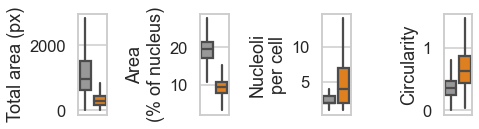

In [61]:
sns.set_style('whitegrid')
sns.set_context('talk')

fig, axes = plt.subplots(1,4, figsize=(7,2), sharex=True, squeeze=False)
# total area 
ax = axes[0][0]
df = adata_object_stats.obsm['size'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Total area (px)')

# relative area
ax = axes[0][1]
df = adata_object_stats.obsm['size'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
df['nucleolus_fraction'] = df['Nucleolus'] / df['all'] * 100
g = sns.boxplot(data=df, y='nucleolus_fraction', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
g.set_ylabel('Area\n(% of nucleus)')

# object count
ax = axes[0][2]
df = adata_object_stats.obsm['object_count'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Nucleoli\nper cell')

# circularity
ax = axes[0][3]
df = adata_object_stats.obsm['object_circularity_median'].copy()
df['perturbation_plot'] = adata.obs['perturbation_plot']
sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Circularity')


for ax in axes.flat:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    #ax.set_xticklabels(cats, rotation = 90)
plt.tight_layout()
plt.savefig(fig_dir/'object_features_CX5461.png', dpi=300)


## Suppl fig: plot number of nucleolus before and after filtering

In [32]:
agg_stats = adata_object_stats.obsm['object_stats_agg']
agg_stats['perturbation'] = adata_object_stats.obs['perturbation_plot']
agg_stats = agg_stats[np.in1d(adata_object_stats.obs['perturbation_plot'], cats)]
agg_stats['perturbation'] = list(agg_stats['perturbation'])

/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_9398/267920546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_stats['perturbation'] = list(agg_stats['perturbation'])


In [31]:
agg_stats

,area_median|Cajal bodies,area_median|Extra-nuclear,area_median|Nuclear periphery,area_median|Nuclear speckles,area_median|Nucleolus,area_median|Nucleoplasm,area_median|PML bodies,area_thresholded_count|Cajal bodies,area_thresholded_count|Extra-nuclear,area_thresholded_count|Nuclear periphery,...,extent_thresholded_median|Nucleoplasm,extent_thresholded_median|PML bodies,count|Cajal bodies,count|Extra-nuclear,count|Nuclear periphery,count|Nuclear speckles,count|Nucleolus,count|Nucleoplasm,count|PML bodies,perturbation
488-5,0.0,36.0,0.0,112.0,1984.5,16.0,55.0,0.0,5.0,0.0,...,0.423177,0.718182,0.0,10.0,0.0,13.0,2.0,3.0,17.0,unperturbed
143-0,0.0,26.0,33.0,109.0,836.0,2499.5,53.0,0.0,4.0,2.0,...,0.398676,0.700000,0.0,7.0,7.0,9.0,2.0,2.0,7.0,unperturbed
610-2,0.0,45.0,21.0,73.0,526.0,2340.0,47.0,0.0,8.0,5.0,...,0.395676,0.654167,0.0,10.0,6.0,13.0,3.0,2.0,9.0,unperturbed
109-1,0.0,1214.0,24.0,92.0,525.0,3040.5,40.0,0.0,1.0,11.0,...,0.381091,0.698052,0.0,1.0,13.0,12.0,4.0,2.0,11.0,unperturbed
630-3,0.0,58.0,12.0,64.0,1793.5,8951.0,115.0,0.0,7.0,5.0,...,0.428729,0.680473,0.0,9.0,5.0,20.0,2.0,1.0,7.0,unperturbed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19-4,0.0,22.0,49.5,107.5,2832.0,9552.0,94.0,0.0,6.0,9.0,...,0.418580,0.713203,0.0,10.0,14.0,16.0,1.0,1.0,11.0,unperturbed
191-12,22.0,34.5,31.0,85.0,593.0,7135.0,33.5,3.0,1.0,4.0,...,0.487363,0.666667,3.0,4.0,9.0,8.0,2.0,1.0,18.0,CX5461 (2.5h)
520-11,17.0,103.0,16.0,71.0,422.0,5998.0,68.0,1.0,1.0,9.0,...,0.413741,0.680000,1.0,3.0,10.0,16.0,4.0,1.0,5.0,CX5461 (2.5h)
138-3,0.0,49.5,51.0,122.0,859.5,41.0,38.0,0.0,3.0,1.0,...,0.565657,0.685714,0.0,6.0,4.0,11.0,2.0,7.0,15.0,unperturbed


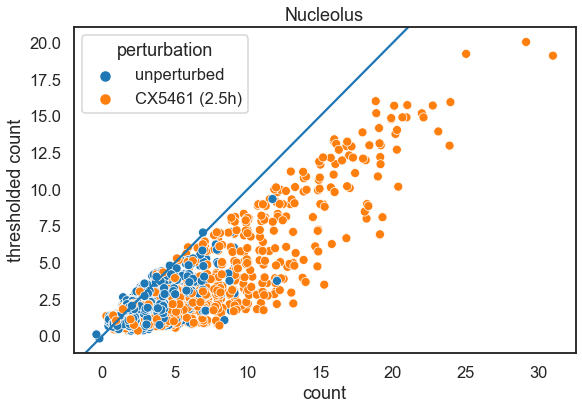

In [45]:
sns.set_style('white')
sns.set_context('talk')

def jitter(values,j=0):
    return values + np.random.normal(j,0.2,values.shape)

order = np.random.permutation(np.arange(len(agg_stats)))
agg_stats = agg_stats.iloc[order]

for cluster in ['Nucleolus']:
    plt.figure(figsize=(9,6))
    sns.scatterplot(x=jitter(agg_stats[f"count|{cluster}"]), y=jitter(agg_stats[f'area_thresholded_count|{cluster}']), hue=agg_stats['perturbation'])
    plt.axline((0,0), slope=1)
    plt.ylabel('thresholded count')
    plt.xlabel('count')
    plt.title(cluster)
    plt.savefig(fig_dir/f'suppl_scatter_counts_{cluster}.png', dpi=200, bbox_inches='tight')